# Análisis Exploratorio de Datos - INE Guatemala

**Estadísticas Vitales: Nacimientos, Defunciones, Matrimonios, Divorcios y Defunciones Fetales**

Datos del Instituto Nacional de Estadística (INE) de Guatemala, período 2012-2022.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as sp_stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from src.query.api import load, agg, yearly_counts, list_datasets, get_column_labels
from src.db import duckdb as duck

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
sns.set_theme(style='whitegrid')

import warnings
warnings.filterwarnings('ignore', message='.*Creating legend with loc.*')
warnings.filterwarnings('ignore', message='.*Tight layout.*')

print('Setup completo')

Setup completo


## 1. Descripción General del Conjunto de Datos

### 1.1 Colecciones disponibles

In [2]:
# Ver todos los datasets y sus estadísticas (desde DuckDB)
duck.register_views()
counts = duck.table_counts()

for name, count in sorted(counts.items()):
    # Get column info from a sample
    sample_df = agg(f"SELECT * FROM {name} LIMIT 1")
    cols = [c for c in sample_df.columns if not c.startswith('_')]
    print(f"{name:25s}: {count:>9,} registros | {len(cols):>3} campos")
    print(f"  Campos: {', '.join(cols[:15])}")
    print()

defunciones              :   950,793 registros |  28 campos
  Campos: depreg, mupreg, mesreg, anioreg, depocu, mupocu, areag, sexo, diaocu, mesocu, anioocu, edadif, perdif, puedif, ecidif

defunciones_fetales      :    28,626 registros |  31 campos
  Campos: depreg, mupreg, mesreg, anioreg, depocu, mupocu, areag, sexo, diaocu, mesocu, anioocu, tipar, clapar, viapar, semges

divorcios                :    71,576 registros |  19 campos
  Campos: depreg, mupreg, mesreg, anioreg, diaocu, mesocu, anioocu, depocu, mupocu, edadhom, edadmuj, puehom, puemuj, nachom, nacmuj

matrimonios              :   842,333 registros |  23 campos
  Campos: depreg, mupreg, mesreg, anioreg, anioocu, clauni, nunuho, nunumu, edadhom, edadmuj, puehom, puemuj, nachom, nacmuj, eschom

nacimientos              : 4,107,969 registros |  44 campos
  Campos: depreg, mupreg, mesreg, anioreg, tipoins, depocu, mupocu, libras, onzas, diaocu, mesocu, anioocu, sexo, tipar, viapar



### 1.2 Cargar dataset principal

In [3]:
# Elegir el dataset a analizar
# Opciones: 'nacimientos', 'defunciones', 'matrimonios', 'divorcios', 'defunciones_fetales'
DATASET = 'defunciones'  # <-- CAMBIAR AQUÍ

# Para datasets grandes (nacimientos ~4M filas), usar muestreo.
# 150k filas es más que suficiente para EDA (distribuciones, correlaciones, clustering).
# Para conteos totales usamos DuckDB directamente (push-down).
SAMPLE_SIZE = 150_000  # 0 = cargar todo (puede consumir mucha RAM en nacimientos)

df = load(DATASET, sample_n=SAMPLE_SIZE)
labels_map = get_column_labels(DATASET)

# Obtener conteo real desde DuckDB
_total = agg(f"SELECT COUNT(*) as n FROM {DATASET}")['n'].iloc[0]

print(f"Dataset: {DATASET}")
print(f"Total en DuckDB: {_total:,}")
print(f"Muestra cargada: {len(df):,} filas ({len(df)/_total*100:.1f}%)")
print(f"Columnas: {len(df.columns)}")
print(f"RAM estimada: {df.memory_usage(deep=True).sum() / 1024**2:.0f} MB")
print(f"Años disponibles: {sorted(df['_year'].dropna().unique().astype(int))}")

Dataset: defunciones
Total en DuckDB: 950,793
Muestra cargada: 150,000 filas (15.8%)
Columnas: 30
RAM estimada: 74 MB
Años disponibles: [np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023)]


In [4]:
# Descripción de cada variable con su label descriptivo
meta_cols = ['_year', '_source_file']
analysis_cols = [c for c in df.columns if c not in meta_cols]

var_info = []
for col in analysis_cols:
    desc = labels_map.get(col, col)
    dtype = str(df[col].dtype)
    n_unique = df[col].nunique()
    n_null = df[col].isnull().sum()
    pct_null = round(n_null / len(df) * 100, 1)
    var_info.append({
        'columna': col,
        'descripcion': desc,
        'tipo': dtype,
        'valores_unicos': n_unique,
        'nulos': n_null,
        'pct_nulos': pct_null
    })

var_df = pd.DataFrame(var_info)
print(f"Total variables de análisis: {len(var_df)}")
var_df

Total variables de análisis: 28


,columna,descripcion,tipo,valores_unicos,nulos,pct_nulos
0,depreg,Departamento de registro,str,27,0,0.0
1,mupreg,Municipio de registro,str,334,0,0.0
2,mesreg,Mes de registro,str,12,0,0.0
3,anioreg,Año de registro,float64,12,0,0.0
4,depocu,Departamento de ocurrencia,str,27,0,0.0
5,mupocu,Municipio de ocurrencia,str,334,0,0.0
6,areag,Área geográfica,str,3,75412,50.3
7,sexo,Sexo del difunto,str,2,0,0.0
8,diaocu,Día de ocurrencia,float64,31,0,0.0
9,mesocu,Mes de ocurrencia,str,12,0,0.0


In [5]:
# Clasificar variables en numéricas y categóricas
# Intentar convertir columnas que parecen numéricas pero están como string
for col in analysis_cols:
    if df[col].dtype == 'object' or str(df[col].dtype).startswith('str'):
        try:
            converted = pd.to_numeric(df[col], errors='coerce')
            if converted.notna().sum() / df[col].notna().sum() > 0.8:
                df[col] = converted
        except Exception:
            pass

num_cols = df[analysis_cols].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in analysis_cols if c not in num_cols]

def label(col, max_len=40):
    """Retorna el label descriptivo, truncado y sin notas."""
    raw = labels_map.get(col, col)
    if 'Nota:' in raw:
        raw = raw.split('Nota:')[0].strip()
    if len(raw) > max_len:
        raw = raw[:max_len-3] + '...'
    return raw

print(f"Variables numéricas ({len(num_cols)}):")
for c in num_cols:
    print(f"  {c:15s} -> {label(c)}")

print(f"\nVariables categóricas ({len(cat_cols)}):")
for c in cat_cols:
    print(f"  {c:15s} -> {label(c)} ({df[c].nunique()} cat.)")

Variables numéricas (4):
  anioreg         -> Año de registro
  diaocu          -> Día de ocurrencia
  anioocu         -> Año de ocurrencia
  edadif          -> Edad del difunto

Variables categóricas (24):
  depreg          -> Departamento de registro (27 cat.)
  mupreg          -> Municipio de registro (334 cat.)
  mesreg          -> Mes de registro (12 cat.)
  depocu          -> Departamento de ocurrencia (27 cat.)
  mupocu          -> Municipio de ocurrencia (334 cat.)
  areag           -> Área geográfica (3 cat.)
  sexo            -> Sexo del difunto (2 cat.)
  mesocu          -> Mes de ocurrencia (12 cat.)
  perdif          -> Período de edad del difunto (5 cat.)
  puedif          -> Pueblo de pertenencia del difunto (9 cat.)
  ecidif          -> Estado civil del difunto (4 cat.)
  escodif         -> Escolaridad del difunto (7 cat.)
  ciuodif         -> Ocupación del difunto (198 cat.)
  pnadif          -> País de nacimiento del difunto (84 cat.)
  dnadif          -> Departamento

## 2. Exploración de Variables Numéricas

### 2.1 Estadísticas descriptivas

In [6]:
# Excluir variables que son solo identificadores (año de registro, año de ocurrencia)
id_cols = [c for c in num_cols if 'reg' in c or (df[c].dropna().between(2000, 2030).mean() > 0.9)]
meaningful_num = [c for c in num_cols if c not in id_cols]

print(f"Variables numéricas de análisis (excluyendo años/IDs): {len(meaningful_num)}")
for c in meaningful_num:
    print(f"  {c}: {label(c)}")

if id_cols:
    print(f"\nExcluidas (años/IDs): {[f'{c} ({label(c)})' for c in id_cols]}")

Variables numéricas de análisis (excluyendo años/IDs): 2
  diaocu: Día de ocurrencia
  edadif: Edad del difunto

Excluidas (años/IDs): ['anioreg (Año de registro)', 'anioocu (Año de ocurrencia)']


In [7]:
# Medidas de tendencia central, dispersión y orden
if meaningful_num:
    desc = df[meaningful_num].describe().T
    desc['mediana'] = df[meaningful_num].median()
    desc['moda'] = df[meaningful_num].mode().iloc[0] if len(df[meaningful_num].mode()) > 0 else None
    desc['asimetria'] = df[meaningful_num].skew()
    desc['curtosis'] = df[meaningful_num].kurtosis()
    desc['cv_%'] = (desc['std'] / desc['mean'] * 100).round(2)
    desc['riq'] = desc['75%'] - desc['25%']
    desc.index = [f"{c} ({label(c)})" for c in desc.index]
    desc
else:
    print("No hay variables numéricas significativas (las existentes son solo años/IDs)")
    print("Esto es normal para este dataset donde la mayoría de variables son categóricas.")
    desc = None

### 2.2 Histogramas

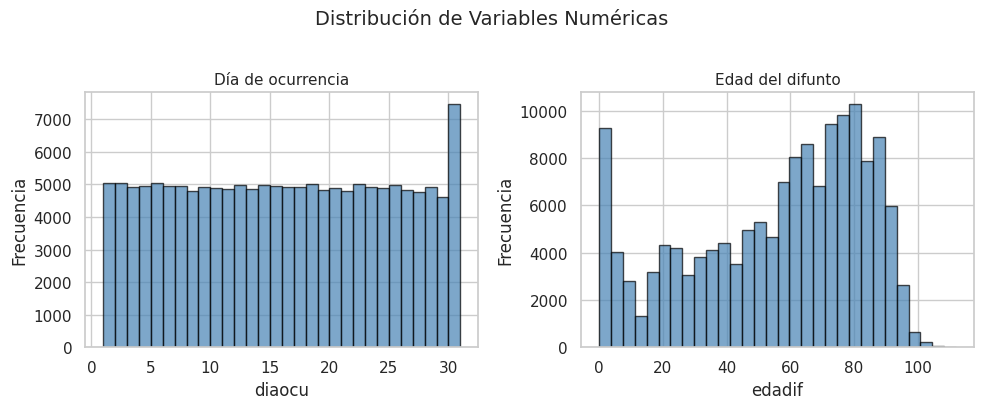

In [8]:
# Histogramas de variables numéricas significativas
plot_num = [c for c in meaningful_num if df[c].nunique() > 2]

if plot_num:
    n = len(plot_num)
    ncols_plot = min(3, n)
    nrows_plot = (n + ncols_plot - 1) // ncols_plot
    fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=(5*ncols_plot, 4*nrows_plot))
    axes = np.array(axes).flatten() if n > 1 else [axes]

    for i, col in enumerate(plot_num):
        ax = axes[i]
        data = df[col].dropna()
        ax.hist(data, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
        ax.set_title(label(col), fontsize=11)
        ax.set_xlabel(col)
        ax.set_ylabel('Frecuencia')

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Distribución de Variables Numéricas', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No hay variables numéricas significativas para graficar histogramas.")

### 2.3 Boxplots

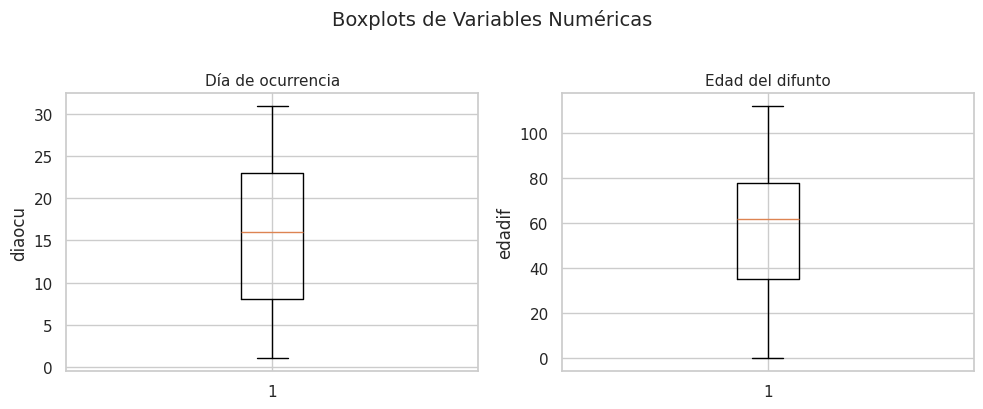

In [9]:
if plot_num:
    n = len(plot_num)
    ncols_plot = min(3, n)
    nrows_plot = (n + ncols_plot - 1) // ncols_plot
    fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=(5*ncols_plot, 4*nrows_plot))
    axes = np.array(axes).flatten() if n > 1 else [axes]

    for i, col in enumerate(plot_num):
        ax = axes[i]
        data = df[col].dropna()
        ax.boxplot(data, vert=True)
        ax.set_title(label(col), fontsize=11)
        ax.set_ylabel(col)

    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle('Boxplots de Variables Numéricas', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("No hay variables numéricas significativas para graficar boxplots.")

### 2.4 Test de normalidad (Shapiro-Wilk)

Se usa una muestra de 5000 observaciones (límite de Shapiro-Wilk).

In [10]:
# Test de normalidad para variables numéricas significativas
normality_results = []
sample_size = 5000

test_cols = meaningful_num if meaningful_num else num_cols

for col in test_cols:
    data = df[col].dropna()
    if len(data) < 3:
        continue
    sample = data.sample(min(sample_size, len(data)), random_state=42)
    stat, p_value = sp_stats.shapiro(sample)
    normality_results.append({
        'variable': col,
        'descripcion': label(col),
        'statistic': round(stat, 4),
        'p_value': f"{p_value:.2e}",
        'normal (α=0.05)': 'Sí' if p_value > 0.05 else 'No',
        'asimetria': round(data.skew(), 3),
    })

norm_df = pd.DataFrame(normality_results)
if len(norm_df) > 0:
    print("Resultados del test de Shapiro-Wilk:")
    display(norm_df)
else:
    print("No hay suficientes variables numéricas para el test de normalidad.")

Resultados del test de Shapiro-Wilk:


,variable,descripcion,statistic,p_value,normal (α=0.05),asimetria
0,diaocu,Día de ocurrencia,0.9538,4.19e-37,No,0.010
1,edadif,Edad del difunto,0.9303,2.44e-43,No,-0.538


## 3. Exploración de Variables Categóricas

### 3.1 Tablas de frecuencia

In [11]:
# Tablas de frecuencia para variables categóricas principales
# Excluir municipios y variables con demasiadas categorías (>50)
main_cat_cols = [c for c in cat_cols if df[c].nunique() <= 50 and df[c].notna().sum() > len(df) * 0.1]

for col in main_cat_cols:
    desc_label = label(col)
    print(f"\n{'='*60}")
    print(f"{col} - {desc_label} ({df[col].nunique()} categorías)")
    print('='*60)

    freq = df[col].value_counts()
    prop = df[col].value_counts(normalize=True) * 100

    table = pd.DataFrame({
        'frecuencia': freq,
        'porcentaje': prop.round(2),
        'acumulado_%': prop.cumsum().round(2)
    })

    if len(table) > 20:
        print(table.head(20))
        print(f"  ... y {len(table) - 20} categorías más")
    else:
        print(table)


depreg - Departamento de registro (27 categorías)
                frecuencia  porcentaje  acumulado_%
depreg                                             
Guatemala            44079       29.39        29.39
Quetzaltenango        9218        6.15        35.53
Alta Verapaz          9017        6.01        41.54
San Marcos            8942        5.96        47.50
Huehuetenango         8433        5.62        53.13
Escuintla             8385        5.59        58.72
Suchitepequez         5777        3.85        62.57
Quiché                5605        3.74        66.30
Chimaltenango         5274        3.52        69.82
Jutiapa               4608        3.07        72.89
Santa Rosa            4121        2.75        75.64
Chiquimula            3734        2.49        78.13
Izabal                3550        2.37        80.50
Totonicapán           3424        2.28        82.78
Retalhuleu            3202        2.13        84.91
Jalapa                2937        1.96        86.87
Petén        

### 3.2 Gráficos de barras

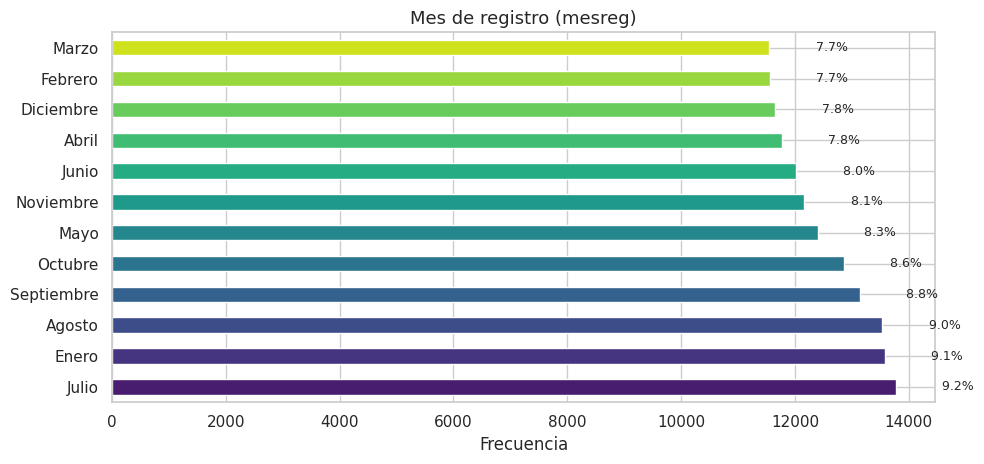

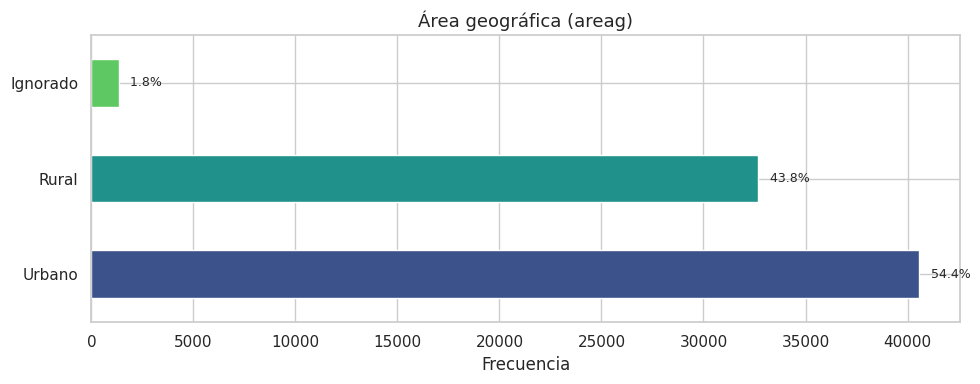

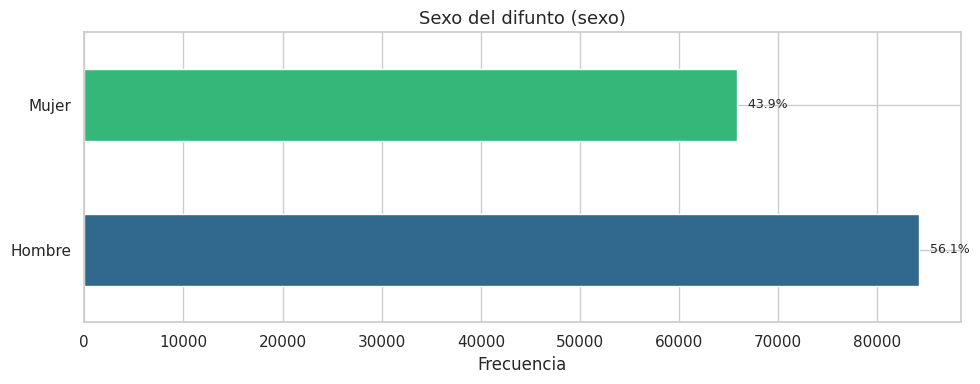

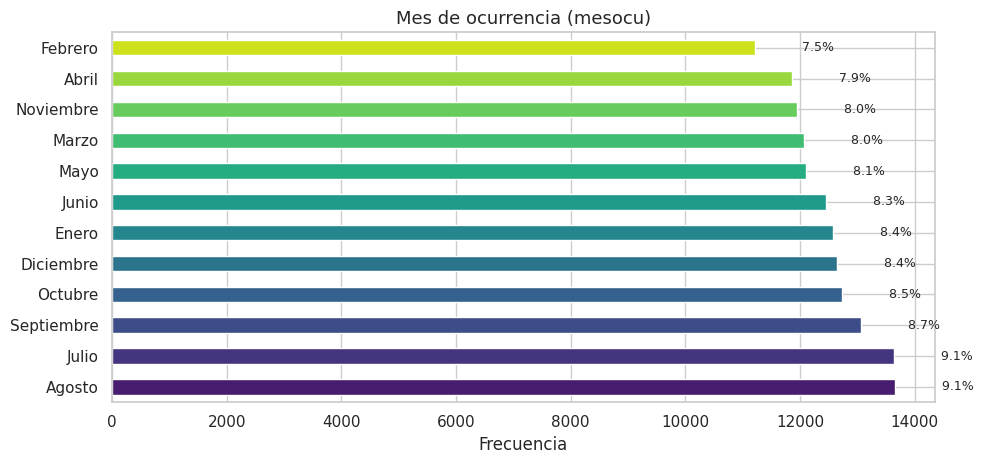

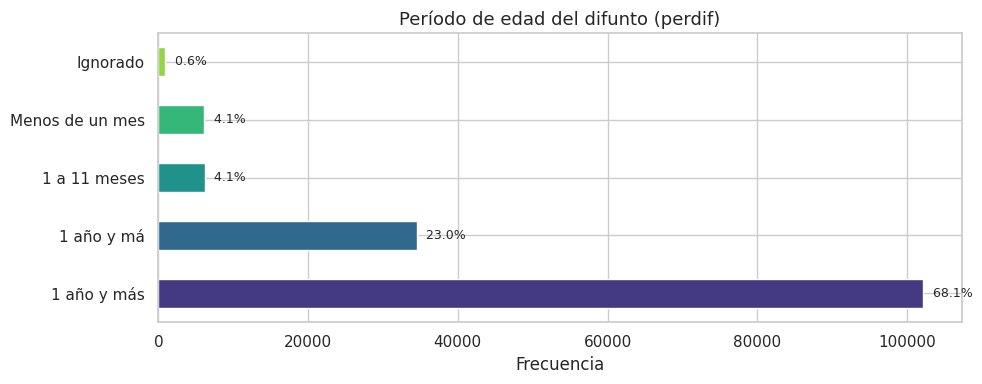

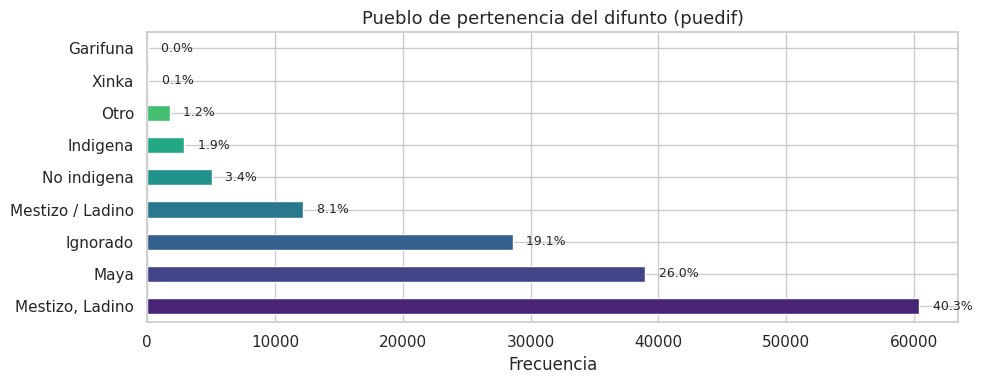

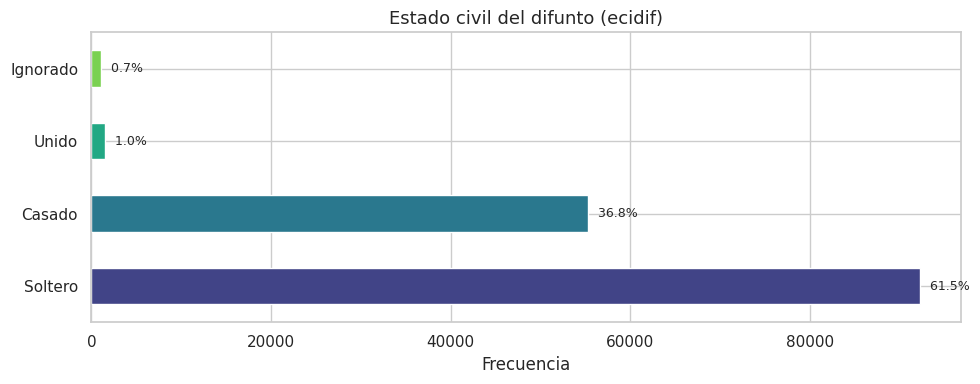

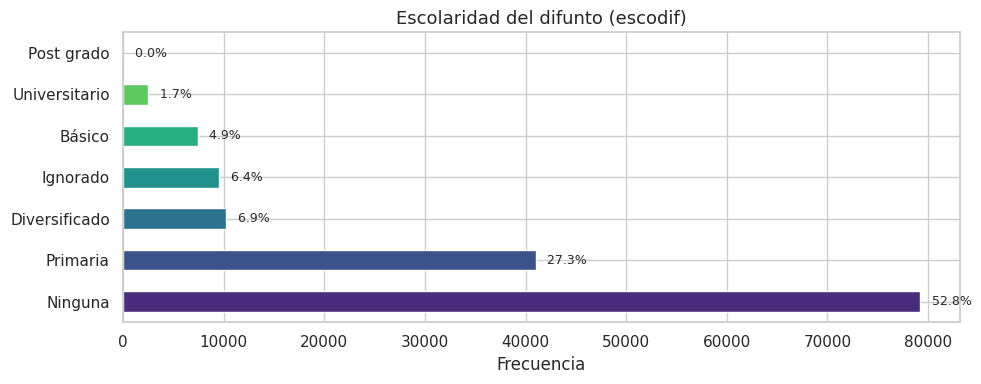

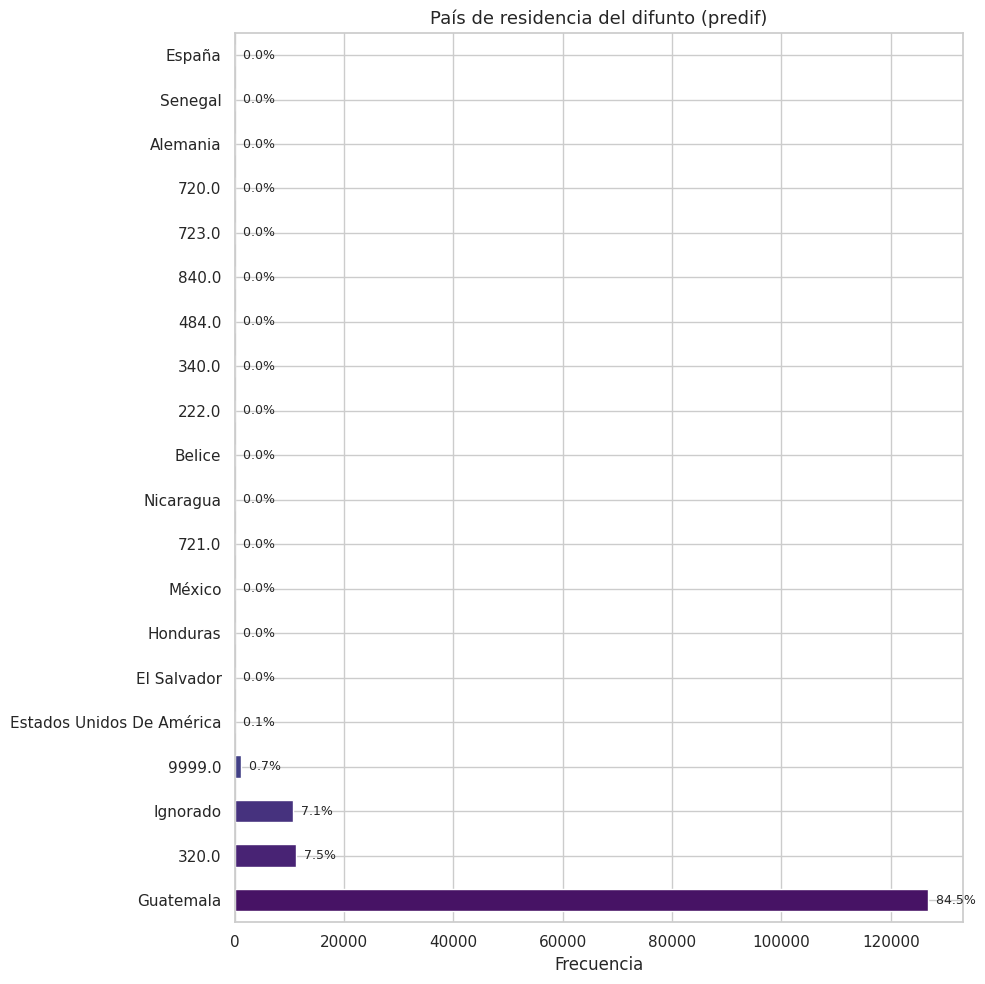

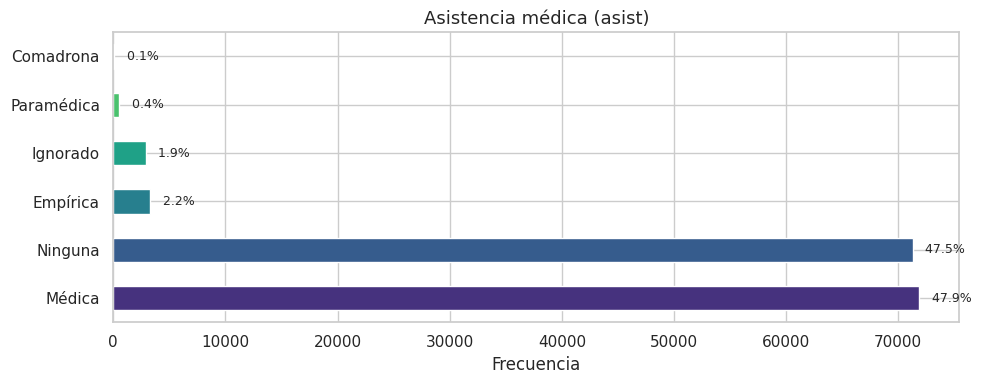

In [12]:
# Gráficos de barras para variables categóricas con pocas categorías
bar_cols = [c for c in main_cat_cols if 2 <= df[c].nunique() <= 25]

for col in bar_cols[:10]:  # Máximo 10 gráficos
    fig, ax = plt.subplots(figsize=(10, max(4, df[col].nunique() * 0.4)))
    freq = df[col].value_counts().head(20)

    colors = sns.color_palette('viridis', len(freq))
    freq.plot(kind='barh', ax=ax, color=colors)
    ax.set_title(f"{label(col)} ({col})", fontsize=13)
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel('')

    # Agregar porcentajes
    total = freq.sum()
    for i, (val, count) in enumerate(freq.items()):
        ax.text(count + total*0.005, i, f" {count/total*100:.1f}%", va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

## 4. Relaciones entre Variables

### 4.1 Matriz de correlación (variables numéricas)

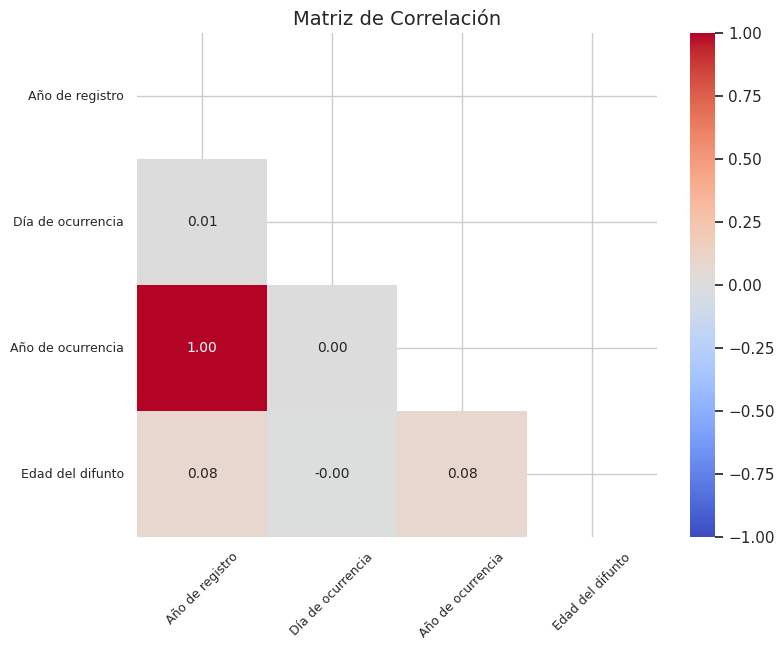


Correlaciones ordenadas por magnitud:


,var1,var2,correlacion
1,anioreg (Año de registro),anioocu (Año de ocurrencia),0.9973
2,anioreg (Año de registro),edadif (Edad del difunto),0.0843
5,anioocu (Año de ocurrencia),edadif (Edad del difunto),0.0824
0,anioreg (Año de registro),diaocu (Día de ocurrencia),0.0065
3,diaocu (Día de ocurrencia),anioocu (Año de ocurrencia),0.0012
4,diaocu (Día de ocurrencia),edadif (Edad del difunto),-0.0009


In [13]:
# Matriz de correlación con todas las numéricas
corr_cols = [c for c in num_cols if df[c].nunique() > 2]

if len(corr_cols) >= 2:
    corr_matrix = df[corr_cols].corr()

    # Labels cortos para el heatmap
    corr_labels = {c: label(c, max_len=25) for c in corr_cols}
    corr_display = corr_matrix.rename(index=corr_labels, columns=corr_labels)

    size = max(8, len(corr_cols) * 2.5)
    fig, ax = plt.subplots(figsize=(size, size * 0.8))
    mask = np.triu(np.ones_like(corr_display, dtype=bool))
    sns.heatmap(corr_display, mask=mask, annot=True, fmt='.2f',
                cmap='coolwarm', center=0, ax=ax, vmin=-1, vmax=1,
                annot_kws={'size': 10})
    ax.set_title('Matriz de Correlación', fontsize=14)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.tick_params(axis='y', rotation=0, labelsize=9)
    plt.subplots_adjust(left=0.25, bottom=0.25)
    plt.show()

    # Top correlaciones
    pairs = []
    for i in range(len(corr_cols)):
        for j in range(i+1, len(corr_cols)):
            pairs.append({
                'var1': f"{corr_cols[i]} ({label(corr_cols[i])})",
                'var2': f"{corr_cols[j]} ({label(corr_cols[j])})",
                'correlacion': round(corr_matrix.iloc[i, j], 4)
            })
    pairs_df = pd.DataFrame(pairs).sort_values('correlacion', key=abs, ascending=False)
    print("\nCorrelaciones ordenadas por magnitud:")
    display(pairs_df)
else:
    print("No hay suficientes variables numéricas para la matriz de correlación.")

### 4.2 Scatter plots

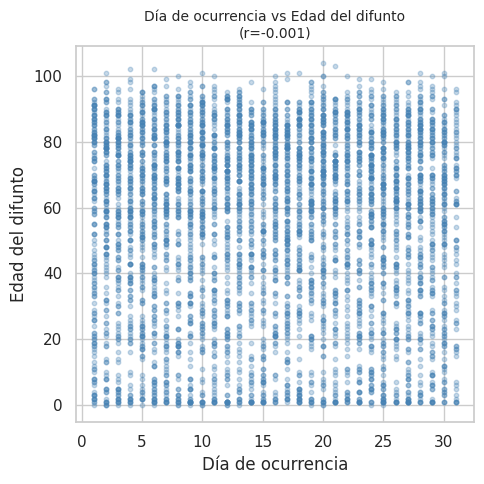

In [14]:
# Scatter plots entre pares de variables numéricas significativas
scatter_cols = meaningful_num if len(meaningful_num) >= 2 else corr_cols

if len(scatter_cols) >= 2:
    from itertools import combinations
    pairs = list(combinations(scatter_cols, 2))[:6]  # Max 6 scatter plots

    n = len(pairs)
    ncols_plot = min(3, n)
    nrows_plot = (n + ncols_plot - 1) // ncols_plot
    fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=(5*ncols_plot, 5*nrows_plot))
    axes = np.array(axes).flatten() if n > 1 else [axes]

    sample = df.sample(min(5000, len(df)), random_state=42)
    for i, (c1, c2) in enumerate(pairs):
        axes[i].scatter(sample[c1], sample[c2], alpha=0.3, s=10, color='steelblue')
        axes[i].set_xlabel(label(c1))
        axes[i].set_ylabel(label(c2))
        r = df[[c1, c2]].dropna().corr().iloc[0, 1]
        axes[i].set_title(f'{label(c1)} vs {label(c2)}\n(r={r:.3f})', fontsize=10)

    for j in range(len(pairs), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No hay suficientes variables numéricas para scatter plots.")

### 4.3 Tablas cruzadas (Crosstabs)

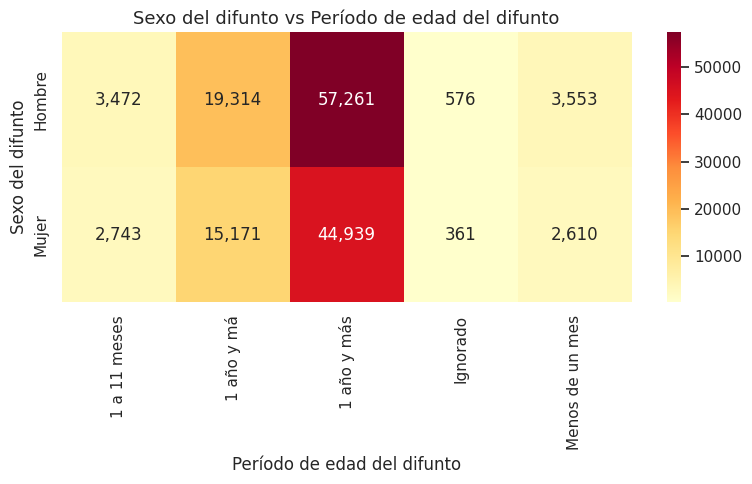

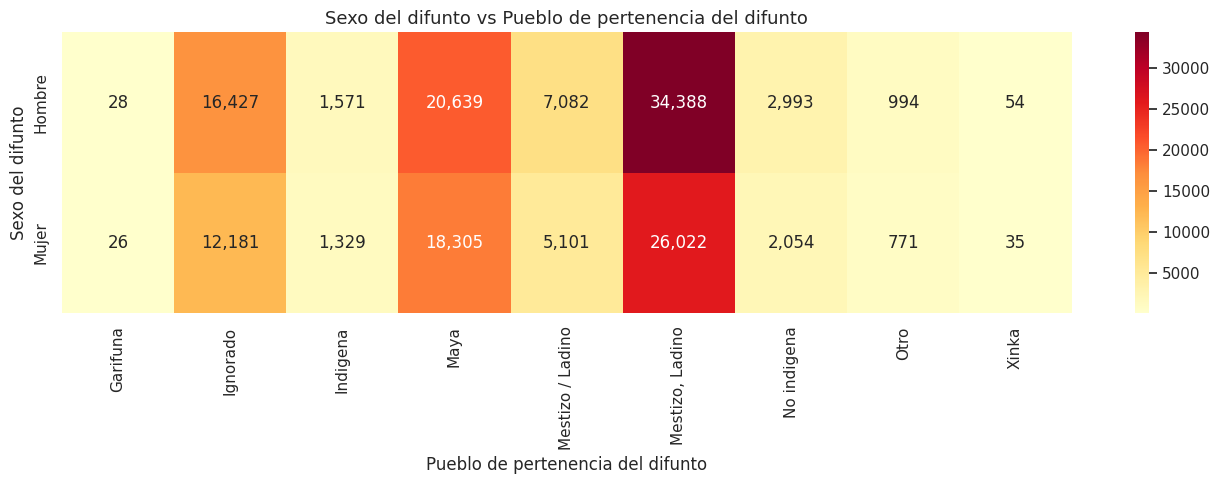

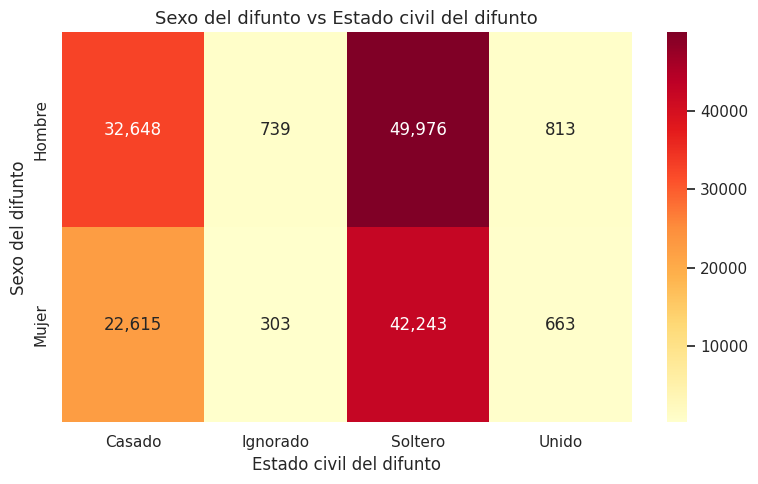

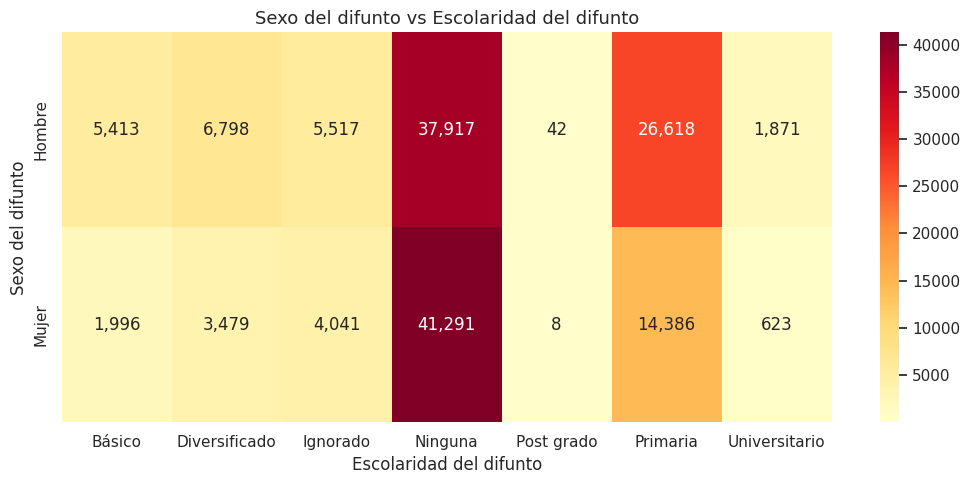

In [15]:
# Crosstabs entre variables categóricas con pocas categorías
cross_candidates = [c for c in cat_cols if 2 <= df[c].nunique() <= 10 and df[c].notna().sum() > len(df) * 0.5]

if len(cross_candidates) >= 2:
    from itertools import combinations
    cross_pairs = list(combinations(cross_candidates[:6], 2))[:4]  # Top 4 cruces

    for c1, c2 in cross_pairs:
        ct = pd.crosstab(df[c1], df[c2])

        fig, ax = plt.subplots(figsize=(max(8, ct.shape[1]*1.5), max(5, ct.shape[0]*0.6)))
        sns.heatmap(ct, annot=True, fmt=',d', cmap='YlOrRd', ax=ax)
        ax.set_title(f'{label(c1)} vs {label(c2)}', fontsize=13)
        ax.set_xlabel(label(c2))
        ax.set_ylabel(label(c1))
        plt.tight_layout()
        plt.show()
else:
    print("No hay suficientes variables categóricas con pocas categorías para crosstabs.")

## 5. Análisis temporal

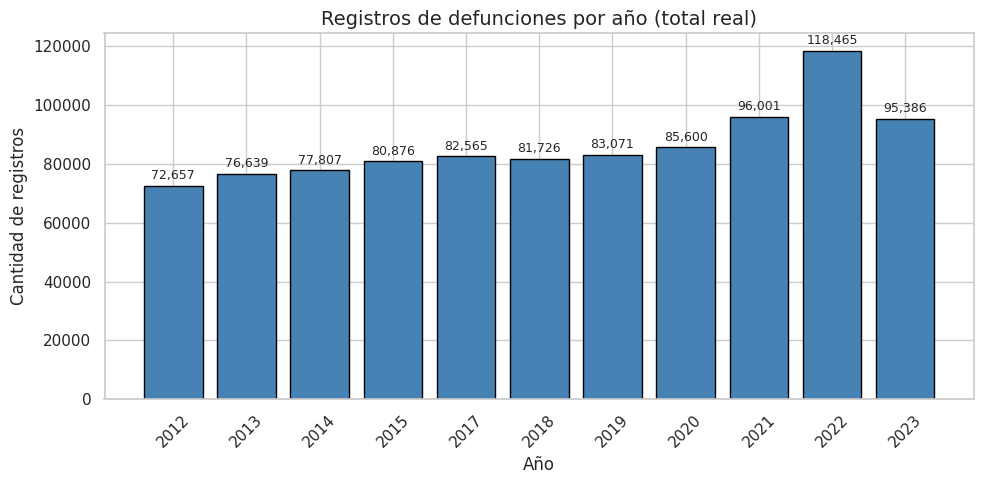

Total real: 950,793


In [16]:
# Registros por año - conteos REALES desde DuckDB (push-down, no usa la muestra)
yearly_df = yearly_counts(DATASET)
yearly = pd.Series(yearly_df['n'].values, index=yearly_df['_year'].values).sort_index()

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(yearly.index.astype(int).astype(str), yearly.values,
              color='steelblue', edgecolor='black')
ax.set_title(f'Registros de {DATASET} por año (total real)', fontsize=14)
ax.set_xlabel('Año')
ax.set_ylabel('Cantidad de registros')
ax.tick_params(axis='x', rotation=45)

for bar, val in zip(bars, yearly.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + yearly.max()*0.01,
            f'{val:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
print(f"Total real: {yearly.sum():,}")

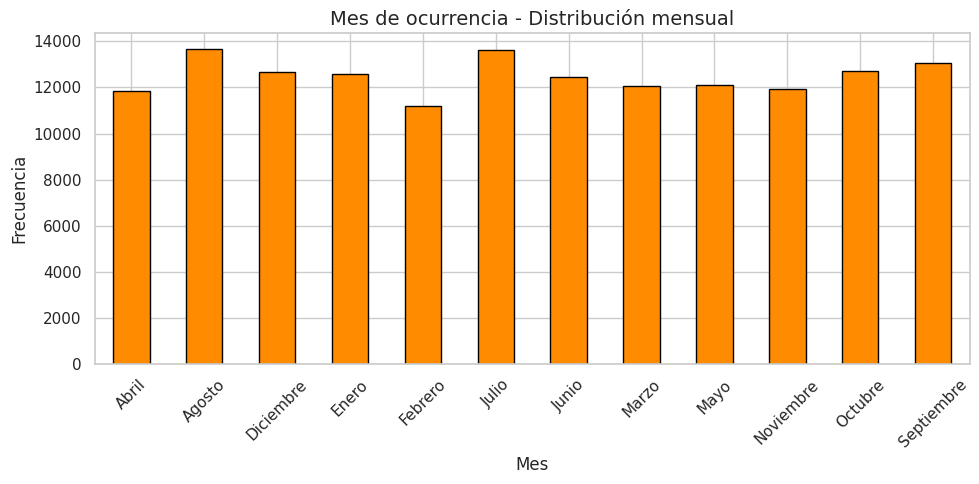

In [17]:
# Distribución por mes de ocurrencia (si existe)
mes_col = None
for c in cat_cols:
    if 'mesocu' in c:
        mes_col = c
        break

if mes_col:
    monthly = df[mes_col].value_counts().sort_index()
    fig, ax = plt.subplots(figsize=(10, 5))
    monthly.plot(kind='bar', ax=ax, color='darkorange', edgecolor='black')
    ax.set_title(f'{label(mes_col)} - Distribución mensual', fontsize=14)
    ax.set_xlabel('Mes')
    ax.set_ylabel('Frecuencia')
    ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

## 6. Datos atípicos (Outliers)

In [18]:
# Detección de outliers con IQR para variables numéricas significativas
outlier_cols = meaningful_num if meaningful_num else [c for c in num_cols if df[c].nunique() > 5]

if outlier_cols:
    outlier_report = []
    for col in outlier_cols:
        data = df[col].dropna()
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        if IQR == 0:
            continue
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        n_outliers = ((data < lower) | (data > upper)).sum()
        outlier_report.append({
            'variable': col,
            'descripcion': label(col),
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'limite_inf': lower,
            'limite_sup': upper,
            'n_outliers': n_outliers,
            'pct_outliers': round(n_outliers / len(data) * 100, 2),
        })

    if outlier_report:
        outlier_df = pd.DataFrame(outlier_report)
        display(outlier_df)
    else:
        print("No se detectaron outliers con el método IQR.")
else:
    print("No hay variables numéricas significativas para análisis de outliers.")
    print("Las variables numéricas existentes son años e IDs, que no aplican.")

,variable,descripcion,Q1,Q3,IQR,limite_inf,limite_sup,n_outliers,pct_outliers
0,diaocu,Día de ocurrencia,8.0,23.0,15.0,-14.5,45.5,0,0.0
1,edadif,Edad del difunto,35.0,78.0,43.0,-29.5,142.5,0,0.0


## 7. Clustering

### 7.1 Preparación de datos

Para clustering usamos tanto variables numéricas como categóricas codificadas.

In [19]:
# Seleccionar variables para clustering
# Excluir: municipios, meses (dominan el one-hot y crean clusters por mes),
# departamentos, y variables con >92% nulos
exclude_cluster = {'mesreg', 'mesocu', 'depreg', 'depocu', 'dredif', 'dnadif'}
cluster_cat = [c for c in cat_cols
               if 2 <= df[c].nunique() <= 15
               and df[c].notna().sum() > len(df) * 0.7
               and c not in exclude_cluster
               and 'mun' not in c and 'mup' not in c]

cluster_num = [c for c in meaningful_num if df[c].notna().sum() > len(df) * 0.7]

print(f"Variables para clustering:")
print(f"  Numéricas ({len(cluster_num)}):")
for c in cluster_num:
    print(f"    - {c}: {label(c)}")
print(f"  Categóricas ({len(cluster_cat)}, se codificarán con one-hot):")
for c in cluster_cat:
    print(f"    - {c}: {label(c)} ({df[c].nunique()} cat.)")

# Preparar DataFrame
df_clust = df[cluster_num + cluster_cat].dropna().copy()

# One-hot encode
if cluster_cat:
    df_encoded = pd.get_dummies(df_clust, columns=cluster_cat, drop_first=False)
else:
    df_encoded = df_clust.copy()

# Estandarizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# Muestra si es muy grande
if len(X_scaled) > 50000:
    np.random.seed(42)
    idx = np.random.choice(len(X_scaled), 50000, replace=False)
    X_sample = X_scaled[idx]
else:
    X_sample = X_scaled

print(f"\nDatos: {X_sample.shape[0]:,} filas x {X_sample.shape[1]} features")

Variables para clustering:
  Numéricas (2):
    - diaocu: Día de ocurrencia
    - edadif: Edad del difunto
  Categóricas (8, se codificarán con one-hot):
    - sexo: Sexo del difunto (2 cat.)
    - perdif: Período de edad del difunto (5 cat.)
    - puedif: Pueblo de pertenencia del difunto (9 cat.)
    - ecidif: Estado civil del difunto (4 cat.)
    - escodif: Escolaridad del difunto (7 cat.)
    - asist: Asistencia médica (6 cat.)
    - ocur: Lugar de ocurrencia (9 cat.)
    - cerdef: Certificado de defunción (6 cat.)

Datos: 50,000 filas x 49 features


### 7.2 Método del codo y silueta para determinar K óptimo

  K=2: inercia=2,268,350, silueta=0.1054
  K=3: inercia=2,178,047, silueta=0.1125
  K=4: inercia=2,114,584, silueta=0.1068
  K=5: inercia=2,055,625, silueta=0.1260
  K=6: inercia=1,998,497, silueta=0.1108
  K=7: inercia=1,947,829, silueta=0.1112
  K=8: inercia=1,897,200, silueta=0.1345


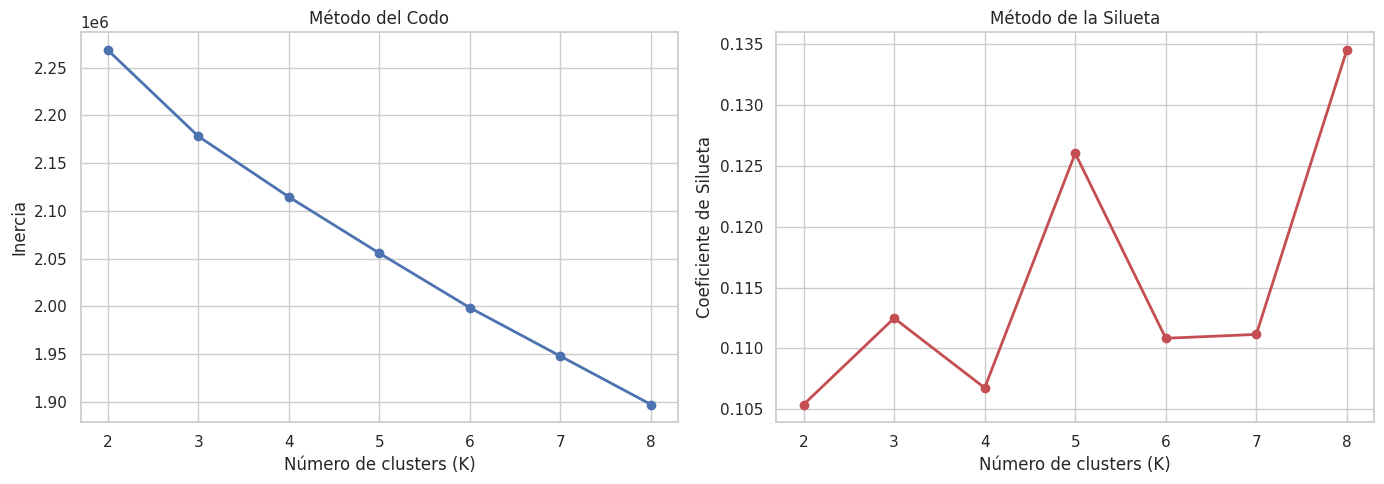


Mejor K según silueta: 8 (score: 0.1345)


In [20]:
K_range = range(2, 9)
inertias = []
silhouettes = []

sil_sample = X_sample[:10000] if len(X_sample) > 10000 else X_sample

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    km_labels = kmeans.fit_predict(X_sample)
    inertias.append(kmeans.inertia_)

    sil_labels = kmeans.predict(sil_sample)
    sil = silhouette_score(sil_sample, sil_labels)
    silhouettes.append(sil)
    print(f"  K={k}: inercia={kmeans.inertia_:,.0f}, silueta={sil:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-', linewidth=2)
ax1.set_xlabel('Número de clusters (K)')
ax1.set_ylabel('Inercia')
ax1.set_title('Método del Codo')

ax2.plot(K_range, silhouettes, 'ro-', linewidth=2)
ax2.set_xlabel('Número de clusters (K)')
ax2.set_ylabel('Coeficiente de Silueta')
ax2.set_title('Método de la Silueta')

plt.tight_layout()
plt.show()

best_k = list(K_range)[np.argmax(silhouettes)]
print(f"\nMejor K según silueta: {best_k} (score: {max(silhouettes):.4f})")

### 7.3 Clustering final e interpretación

In [21]:
# Clustering con K óptimo
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled[:len(df_clust)])
df_clust['cluster'] = cluster_labels

print(f"Distribución de clusters (K={best_k}):")
cluster_dist = df_clust['cluster'].value_counts().sort_index()
for cl, count in cluster_dist.items():
    print(f"  Cluster {cl}: {count:>9,} ({count/len(df_clust)*100:.1f}%)")

Distribución de clusters (K=8):
  Cluster 0:     3,282 (2.2%)
  Cluster 1:    22,344 (15.0%)
  Cluster 2:    33,712 (22.6%)
  Cluster 3:    25,980 (17.4%)
  Cluster 4:       545 (0.4%)
  Cluster 5:    33,409 (22.4%)
  Cluster 6:    12,326 (8.3%)
  Cluster 7:    17,465 (11.7%)


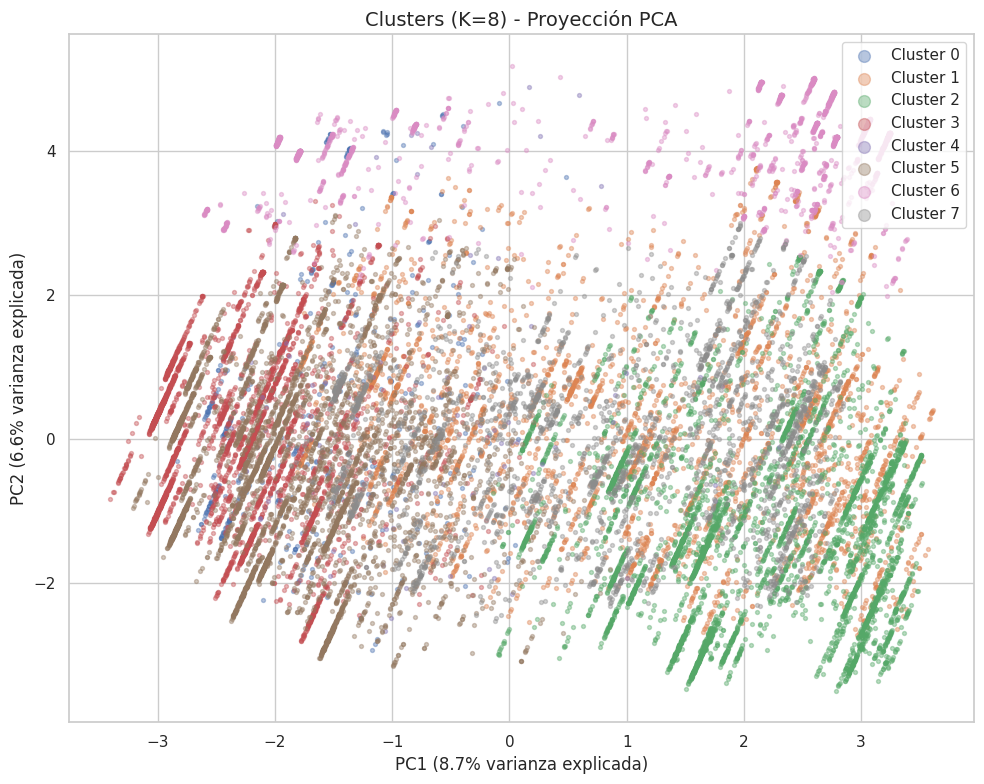

In [22]:
# Visualizar clusters con PCA (muestra para rendimiento)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled[:len(df_clust)])

plot_n = min(20000, len(X_pca))
np.random.seed(42)
plot_idx = np.random.choice(len(X_pca), plot_n, replace=False)

fig, ax = plt.subplots(figsize=(10, 8))
for cl in range(best_k):
    mask = cluster_labels[plot_idx] == cl
    ax.scatter(X_pca[plot_idx[mask], 0], X_pca[plot_idx[mask], 1],
              alpha=0.4, s=8, label=f'Cluster {cl}')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza explicada)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza explicada)')
ax.set_title(f'Clusters (K={best_k}) - Proyección PCA', fontsize=14)
ax.legend(loc='upper right', markerscale=3)
plt.tight_layout()
plt.show()

In [23]:
# Interpretar clusters: perfil de cada cluster con variables categóricas
print("=== Perfil de cada cluster ===")
for cat_col in cluster_cat:
    print(f"\n--- {label(cat_col)} ({cat_col}) ---")
    ct = pd.crosstab(df_clust['cluster'], df_clust[cat_col], normalize='index') * 100
    print(ct.round(1).to_string())

=== Perfil de cada cluster ===

--- Sexo del difunto (sexo) ---
sexo     Hombre  Mujer
cluster               
0          52.6   47.4
1          59.5   40.5
2          54.4   45.6
3           0.0  100.0
4          61.7   38.3
5          98.4    1.6
6          56.7   43.3
7          57.7   42.3

--- Período de edad del difunto (perdif) ---
perdif   1 a 11 meses  1 año y má  1 año y más  Menos de un mes
cluster                                                        
0                 6.3        25.4         66.1              2.3
1                 0.0       100.0          0.0              0.0
2                 0.0         0.0        100.0              0.0
3                 0.0        21.7         78.3              0.0
4                 4.2        23.9         67.0              5.0
5                 0.0        16.3         83.7              0.0
6                48.6         0.7          1.6             49.1
7                 0.0         0.0        100.0              0.0

--- Pueblo de perte

=== Medias de variables numéricas por cluster ===


,diaocu (Día de ocurrencia),edadif (Edad del difunto)
cluster,,
0,15.72,55.56
1,15.54,58.11
2,15.77,61.72
3,15.63,64.24
4,14.98,46.56
5,15.68,56.94
6,15.79,6.01
7,15.81,58.77


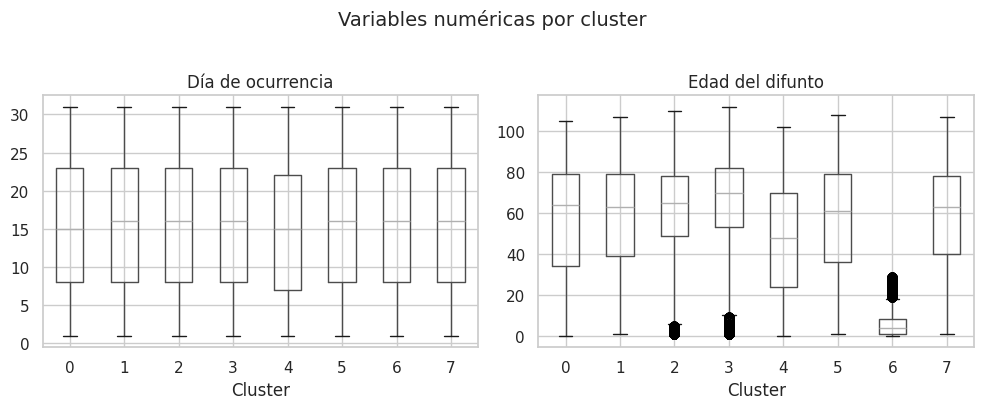

In [24]:
# Perfil numérico por cluster
if cluster_num:
    print("=== Medias de variables numéricas por cluster ===")
    cluster_means = df_clust.groupby('cluster')[cluster_num].mean()
    cluster_means.columns = [f"{c} ({label(c)})" for c in cluster_means.columns]
    display(cluster_means.round(2))

    # Boxplots por cluster
    n = len(cluster_num)
    if n > 0:
        ncols_plot = min(3, n)
        nrows_plot = (n + ncols_plot - 1) // ncols_plot
        fig, axes = plt.subplots(nrows_plot, ncols_plot, figsize=(5*ncols_plot, 4*nrows_plot))
        axes = np.array(axes).flatten() if n > 1 else [axes]

        for i, col in enumerate(cluster_num):
            df_clust.boxplot(column=col, by='cluster', ax=axes[i])
            axes[i].set_title(label(col))
            axes[i].set_xlabel('Cluster')

        for j in range(n, len(axes)):
            axes[j].set_visible(False)

        plt.suptitle('Variables numéricas por cluster', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()